# Fake news detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,Democrats look to future after dispiriting los...,WASHINGTON (Reuters) - Frustrated Democrats po...,politicsNews,"June 21, 2017",true
1,BOOM! LIBS GO NUTS After BETSY DEVOS Announces...,"President Trump s Secretary of Education, Bets...",left-news,"Sep 7, 2017",fake
2,DEMOCRAT SENATOR Reprimanded For Comparing Fem...,A Democratic Senator tried to compare Trump no...,politics,"Nov 29, 2017",fake
3,Watch Trump Shove Foreign Leader Out Of The W...,Donald Trump met with the other members of NAT...,News,"May 25, 2017",fake
4,Florida Judge Blames Rape Victim For Attendin...,The Ultra Music Festival in Miami is one of th...,News,"March 23, 2016",fake


In [9]:
# Removing the date (it is not relevant to the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Democrats look to future after dispiriting los...,WASHINGTON (Reuters) - Frustrated Democrats po...,politicsNews,true
1,BOOM! LIBS GO NUTS After BETSY DEVOS Announces...,"President Trump s Secretary of Education, Bets...",left-news,fake
2,DEMOCRAT SENATOR Reprimanded For Comparing Fem...,A Democratic Senator tried to compare Trump no...,politics,fake
3,Watch Trump Shove Foreign Leader Out Of The W...,Donald Trump met with the other members of NAT...,News,fake
4,Florida Judge Blames Rape Victim For Attendin...,The Ultra Music Festival in Miami is one of th...,News,fake


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Donald Trump is an idiot. Ted Cruz is also an ...,News,fake
1,The White House is getting really nervous toda...,News,fake
2,(Reuters) - A third of Republican voters who s...,politicsNews,true
3,MOSCOW (Reuters) - Former Russian economy mini...,worldnews,true
4,(Reuters) - Hackers targeted the computer syst...,politicsNews,true


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,donald trump is an idiot. ted cruz is also an ...,News,fake
1,the white house is getting really nervous toda...,News,fake
2,(reuters) - a third of republican voters who s...,politicsNews,true
3,moscow (reuters) - former russian economy mini...,worldnews,true
4,(reuters) - hackers targeted the computer syst...,politicsNews,true


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,donald trump is an idiot ted cruz is also an i...,News,fake
1,the white house is getting really nervous toda...,News,fake
2,reuters a third of republican voters who supp...,politicsNews,true
3,moscow reuters former russian economy ministe...,worldnews,true
4,reuters hackers targeted the computer systems...,politicsNews,true


In [15]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\ABDULSHAKUR
[nltk_data]     GALLA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [16]:
data.head()

,text,subject,target
0,donald trump idiot ted cruz also idiot ted cru...,News,fake
1,white house getting really nervous today donal...,News,fake
2,reuters third republican voters support donald...,politicsNews,true
3,moscow reuters former russian economy minister...,worldnews,true
4,reuters hackers targeted computer systems pres...,politicsNews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


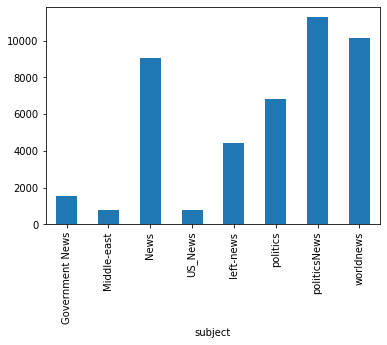

In [17]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


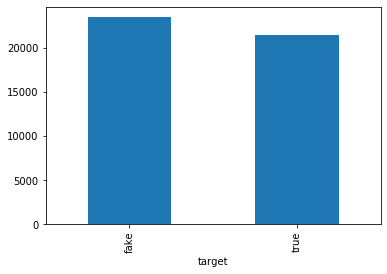

In [18]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [19]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [20]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [21]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

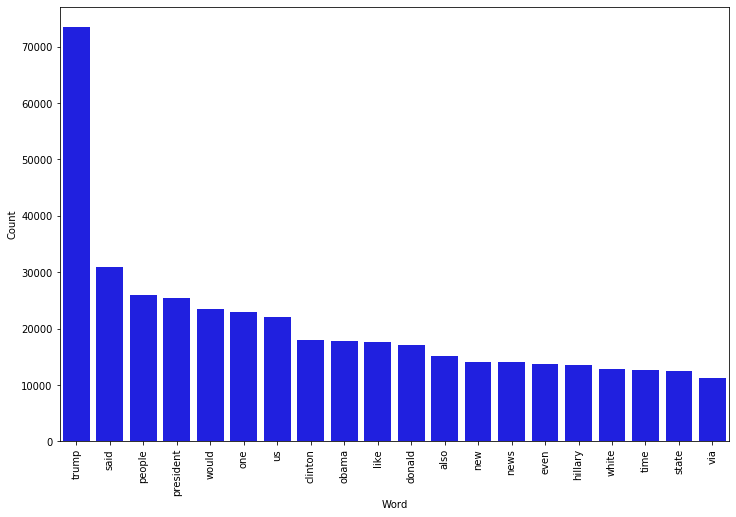

In [68]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

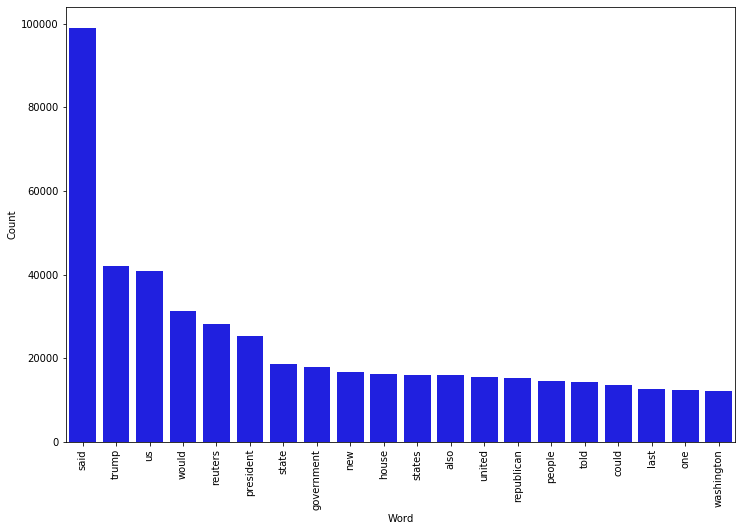

In [69]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [22]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [23]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [24]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

C:\Users\ABDULSHAKUR GALLA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy: 98.99%


Confusion matrix, without normalization


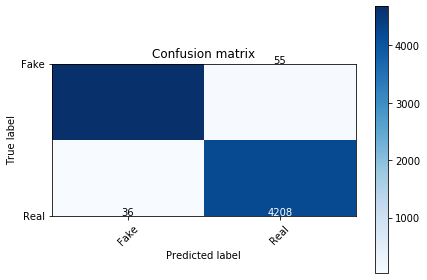

In [25]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4736
        true       0.99      0.99      0.99      4244

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



### Decision Tree Classifier

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.71%


Confusion matrix, without normalization


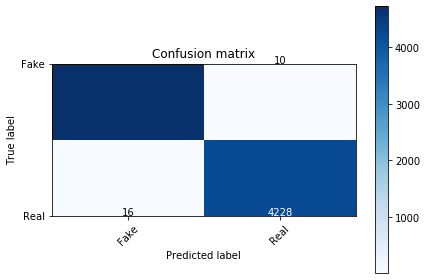

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      4736
        true       1.00      1.00      1.00      4244

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



### Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.0%


Confusion matrix, without normalization


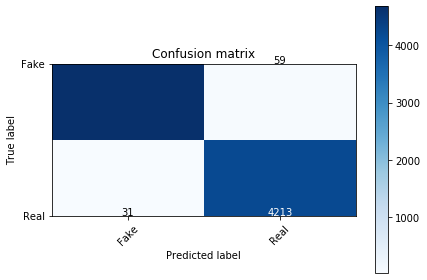

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4736
        true       0.99      0.99      0.99      4244

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

